In this notebook, we import spiking data from Kohn's lab used by Ruben in the Fano factor analaysis paper. 

The description given by Adam in the email is as follows:

-stim: identifiers for the different oris, 1:8, and the order in which they were presented (e.g. length 2400 with 8 oris each shown 300 times);

-cellids: the electrode and sortcode for each unit (probably not important for you)

-spikes: 1x2 cell array, each array is cells x duration (500 ms blank followed by 1280 ms stimulus followed by 1000 ms blank = 2780 points) x repeats (e.g. 2400)

-dur: the duration of the different epochs (500 ms, 1280 ms, 1000 ms).

**Some of my notes:**

matlab_data['spikes'][0, 0] ([0, 1] for V2)returns V1 data a numpy array of the following shape, (neurons_id, time, trials).

For V1 the shape is: (131, 2780, 2400)
For V2 the shape is: (30, 2780, 2400)

In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load the MATLAB file
# fileloc = '../data/2013/109l001p39p41_sorted_large_gratings.mat'
fileloc = '../data/2013/112r001p61p62_sorted_large_gratings.mat'
matlab_data = scipy.io.loadmat(fileloc)

In [3]:
# print the keys of the dictionary
matlab_data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'cellids', 'dur', 'spikes', 'stim'])

In [4]:
# assign the data to different varibales based on their key names
cellids = matlab_data['cellids']
dur = matlab_data['dur']
spikes1 = matlab_data['spikes'][0, 0]
spikes2 = matlab_data['spikes'][0, 1]
stim = matlab_data['stim'].squeeze()

# print the shapes
print(spikes1.shape)
print(spikes2.shape)
print(stim.shape)

(116, 2780, 2000)
(28, 2780, 2000)
(2000,)


In [5]:
def extract_stim_data(data):
    """
    Deletes the data corresponding to blank stimulus.
    """
    return data[:, 500:500+1280, :]

In [6]:
stim_v1 = extract_stim_data(spikes1)
# stim_v1 = spikes1
print(stim_v1.shape)

(116, 1280, 2000)


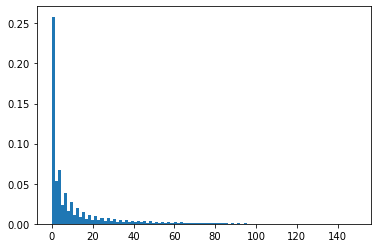

In [7]:
# plot the total number of spikes for each neuron as a histogram
plt.hist(np.sum(stim_v1, axis=1).flatten(), bins=100, density=True)
plt.show()

### Now we try to reproduce the Fano factor plot.

In [8]:
all_data = stim_v1.transpose(0, 2, 1).reshape(-1, stim_v1.shape[1])

print(all_data.shape)

(232000, 1280)


In [9]:
# find the sum of spikes for each neuron and remove the neurons with less than 10 spikes
sum_spikes = np.sum(all_data, axis=1)
print(sum_spikes.shape)
all_data = all_data[sum_spikes > 10, :]
print(all_data.shape)

(232000,)
(64662, 1280)


In [10]:
time_window = 50

window = np.ones(time_window)

spike_counts = np.zeros((all_data.shape[0], all_data.shape[1] // time_window))
for i in range(all_data.shape[0]):
    for j in range(0, all_data.shape[1] // time_window):
        start_idx = j * time_window
        end_idx = start_idx + time_window
        spike_counts[i, j] = np.sum(all_data[i, start_idx:end_idx])


In [11]:
spike_counts[0, :]

array([0., 3., 1., 0., 0., 2., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 1., 0., 0.])

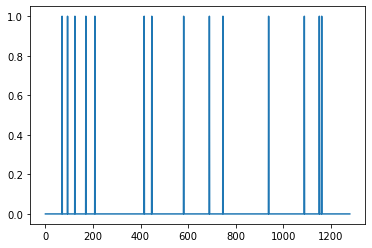

In [12]:
plt.plot(all_data[100, :])

In [13]:
mean_spike_counts = np.mean(spike_counts, axis=1)
var_spike_counts = np.var(spike_counts, axis=1)

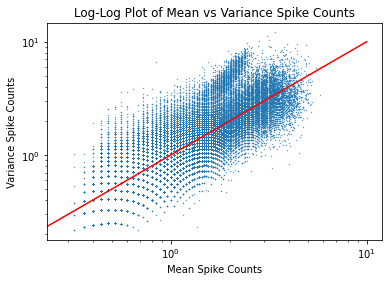

In [14]:
# scatter plot of mean on x axis and variance on y axis alomg with the line y=x in loglog

plt.scatter(mean_spike_counts, var_spike_counts, s=0.1)  # Reduced point size
plt.xscale('log')
plt.yscale('log')
plt.plot([0, 10], [0, 10], 'r')
plt.xlabel('Mean Spike Counts')
plt.ylabel('Variance Spike Counts')
plt.title('Log-Log Plot of Mean vs Variance Spike Counts')
plt.show()


### Now we calculate the average across trials with same stimulus presentation.

In [15]:
stim_indices = {}
for i in range(1, 9):
    stim_indices[i] = np.where(stim == i)[0]

In [16]:
all_data = stim_v1.transpose(2, 0, 1)
print(all_data.shape)
mean_spike_counts = []
var_spike_counts = []

for i in range(1,9):
    mean_spike_counts.append(np.mean(np.sum(all_data[stim_indices[i], :, :], axis=2), axis=0))
    var_spike_counts.append(np.var(np.sum(all_data[stim_indices[i], :, :], axis=2), axis=0))

mean_spike_counts = np.array(mean_spike_counts).flatten()
var_spike_counts = np.array(var_spike_counts).flatten()

# print shapes
print(mean_spike_counts.shape)
print(var_spike_counts.shape)

(2000, 116, 1280)
(928,)
(928,)


In [17]:
np.sum(all_data[stim_indices[1], :, :], axis=2)[:, 50]

array([ 0,  0, 38,  2,  1,  9,  1,  2, 46,  1, 47, 43,  1,  2,  4,  2,  1,
        1,  1,  0,  0,  1,  1,  0,  3,  1,  1,  0,  6,  0, 63,  3,  7,  2,
        1,  1, 25, 13, 11,  2,  8,  0, 41,  0, 62,  1, 63, 14,  2, 56,  5,
       11,  3, 57,  1,  1,  1,  5,  8,  1,  0, 15,  1,  1,  2,  0,  3,  0,
        1,  6,  6,  6,  1,  2,  7,  0,  5,  9,  1,  1,  7, 65,  2,  4,  4,
        1,  2,  2, 10,  2,  8,  0,  8,  1,  6, 35,  0, 81,  1,  9,  0,  5,
       64,  0, 11,  4, 14, 10, 58,  7,  0, 62,  0,  0,  2,  6, 15,  2,  1,
        1,  0,  2,  1,  0,  4,  4,  7,  0,  1,  1,  6, 60,  2,  0,  1, 55,
        5,  1,  8,  1,  0,  1,  1,  1,  1, 50,  0,  0,  4,  5,  0, 12,  0,
        0,  3,  3,  0,  2,  1,  2,  0,  0,  1, 80, 40,  0,  5, 14,  0,  0,
        0, 16,  1,  0,  4,  7,  2,  1, 57,  0,  6,  0,  0,  0,  0, 19,  1,
        2,  0,  0,  4, 75,  1,  1, 18,  1,  3, 13, 46, 52,  6,  5,  1,  0,
        1,  0,  1, 64,  2,  0,  0,  2,  3,  4,  0,  2, 12, 34,  0, 79,  1,
       42,  0,  0, 33,  1

In [18]:
np.var(np.sum(all_data[stim_indices[1], :, :], axis=2), axis=0).shape

(116,)

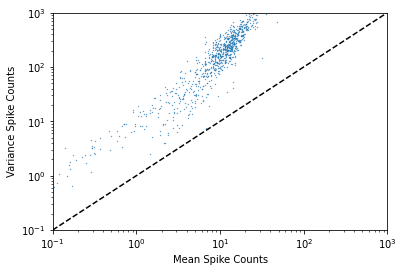

In [19]:
# scatter plot of mean on x axis and variance on y axis alomg with the line y=x in loglog
plt.scatter(mean_spike_counts, var_spike_counts, s=0.1)  # Reduced point size
plt.xscale('log')
plt.yscale('log')
plt.plot([0.1, 1000], [0.1, 1000], '--k')
plt.xlim(0.1, 1000)
plt.ylim(0.1, 1000)
plt.xlabel('Mean Spike Counts')
plt.ylabel('Variance Spike Counts')
# plt.title('Log-Log Plot of Mean vs Variance Spike Counts')
plt.show()

/var/folders/3z/_y1rrv110j183_s1s0787j5c00010t/T/ipykernel_55550/2158423256.py:2: RuntimeWarning: invalid value encountered in divide
  fano_factors = var_spike_counts / mean_spike_counts


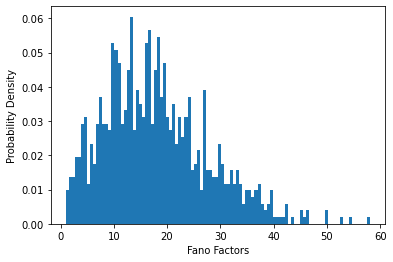

In [20]:
# calculate and plot the probability density of fano factors
fano_factors = var_spike_counts / mean_spike_counts
plt.hist(fano_factors, bins=100, density=True)
plt.xlabel('Fano Factors')
plt.ylabel('Probability Density')
plt.show()

In [21]:
# testing if the data makes sense
np.sum(all_data[stim_indices[1], :, :], axis=2)[:, 50]

array([ 0,  0, 38,  2,  1,  9,  1,  2, 46,  1, 47, 43,  1,  2,  4,  2,  1,
        1,  1,  0,  0,  1,  1,  0,  3,  1,  1,  0,  6,  0, 63,  3,  7,  2,
        1,  1, 25, 13, 11,  2,  8,  0, 41,  0, 62,  1, 63, 14,  2, 56,  5,
       11,  3, 57,  1,  1,  1,  5,  8,  1,  0, 15,  1,  1,  2,  0,  3,  0,
        1,  6,  6,  6,  1,  2,  7,  0,  5,  9,  1,  1,  7, 65,  2,  4,  4,
        1,  2,  2, 10,  2,  8,  0,  8,  1,  6, 35,  0, 81,  1,  9,  0,  5,
       64,  0, 11,  4, 14, 10, 58,  7,  0, 62,  0,  0,  2,  6, 15,  2,  1,
        1,  0,  2,  1,  0,  4,  4,  7,  0,  1,  1,  6, 60,  2,  0,  1, 55,
        5,  1,  8,  1,  0,  1,  1,  1,  1, 50,  0,  0,  4,  5,  0, 12,  0,
        0,  3,  3,  0,  2,  1,  2,  0,  0,  1, 80, 40,  0,  5, 14,  0,  0,
        0, 16,  1,  0,  4,  7,  2,  1, 57,  0,  6,  0,  0,  0,  0, 19,  1,
        2,  0,  0,  4, 75,  1,  1, 18,  1,  3, 13, 46, 52,  6,  5,  1,  0,
        1,  0,  1, 64,  2,  0,  0,  2,  3,  4,  0,  2, 12, 34,  0, 79,  1,
       42,  0,  0, 33,  1

In [22]:
stim_indices[1]

array([   4,   12,   23,   26,   34,   42,   52,   56,   65,   72,   84,
         92,  100,  108,  112,  126,  134,  136,  150,  155,  163,  172,
        180,  188,  197,  201,  213,  219,  226,  239,  244,  248,  258,
        266,  274,  285,  293,  301,  309,  317,  320,  334,  342,  350,
        357,  365,  373,  382,  385,  392,  401,  413,  418,  426,  433,
        445,  453,  456,  471,  479,  483,  491,  498,  509,  518,  527,
        535,  542,  544,  553,  562,  570,  576,  587,  593,  601,  609,
        616,  631,  639,  643,  651,  658,  666,  674,  682,  690,  701,
        706,  716,  724,  732,  740,  748,  756,  761,  769,  777,  785,
        793,  805,  813,  822,  830,  838,  841,  849,  859,  864,  873,
        881,  890,  897,  905,  913,  926,  928,  940,  948,  956,  967,
        974,  982,  990,  992, 1003, 1011, 1017, 1025, 1034, 1042, 1050,
       1058, 1071, 1078, 1086, 1088, 1103, 1111, 1112, 1120, 1135, 1139,
       1149, 1156, 1164, 1170, 1177, 1185, 1193, 12

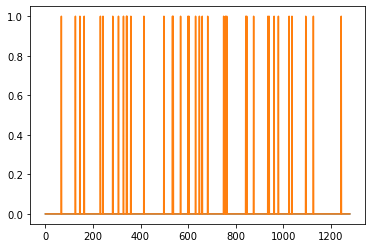

In [23]:
t1 = stim_v1[50, :, 4]
t2 = stim_v1[50, :, 23]

# plot them
plt.plot(t1)
plt.plot(t2)
plt.show()

Code for ratios

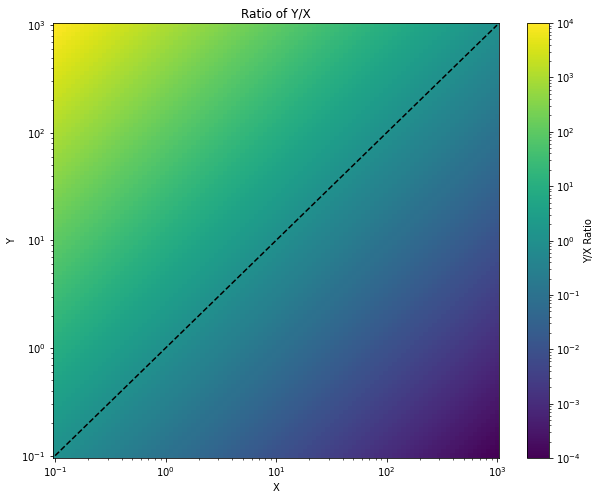

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# Define x and y with logspace spacing
x = np.logspace(-1, 3, 100)  # 100 points from 10^-1 to 10^3
y = np.logspace(-1, 3, 100)

# Create meshgrid
X, Y = np.meshgrid(x, y)

# Calculate the ratio Y/X
ratio = Y / X

# Visualize using a logarithmic colormap
plt.figure(figsize=(10, 8))
plt.pcolormesh(X, Y, ratio, cmap='viridis', norm=LogNorm())
# make y=x line as well
plt.plot(x, x, 'k--', label='y=x')


plt.colorbar(label='Y/X Ratio')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Ratio of Y/X')
plt.show()